---
title: Measuring Distance Between Utility Profiles
date: April 2022
---

In [1]:
#| echo: false
#| output: false

# Set working directory to project root
# only run once in session!
setwd("../")
getwd()

[1] "/Users/tnowacki/github/strategicvoting"

In [2]:
#| echo: false
#| output: false

# Load packages and data
library(tidyverse)
library(gtools)
library(fields)
library(ggsci)
library(ggtern)
library(devtools)
source_url('https://raw.githubusercontent.com/tobiasnowacki/RTemplates/master/plottheme.R')

# Load functions
source("code/utils/new_sv_iter.R")
# Load data
load("output/big_list_2.RData")
vap <- read.csv("data/case_vap.csv", sep = "") # voting age pop.
cat("Data imported. \n")
source("code/prep_cses.R")  # data prep
systems <- read.csv("data/systems.csv")


-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.6     v dplyr   1.0.8
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.0.2     v forcats 0.5.1

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Loading required package: spam

Spam version 2.8-0 (2022-01-05) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: 'spam'


The following objects are masked from 'package:base':

    backsolve, forwardsolve


Loading required package: viridis

Loading required package: viridisLite


Try help(fields) to get started.

Registered S3 methods overwritten by 'ggtern':
  method           from   
  grid.draw.ggplot ggplot2

Data imported. 


Joining, by = "cntry"


big_list_na_omit prepared. 


# Calculating distances between pairs of cases conditional on voter type

Every case's preference profile is described by a $\mathbf{U}$ matrix with dimensions $n \times k$.

1. Generate `average voter' for each voter type ($ABC$) and case $j$, e.g.

$$
\bar{\mathbf{u}}_{j, \ ABC} = \frac{\sum^{n}_{i = 1, \ i \in ABC} \mathbf{u}_{ij}}{n}
$$

2. Create a Euclidian distance matrix for all possible combinations of average voter vectors ***for the same voter type***:

$$
\mathbf{D}_{ABC}
$$

where the Euclidean distance between two cases' ($p$ and $q$) average ABC profiles is stored in cell $pq$:
  $$
  D_{ABC, \ pq} = \sqrt{\sum (\bar{\mathbf{u}}_{p, \ ABC} - \bar{\mathbf{u}}_{q, \ ABC})^2}
  $$ 

3. Finally, take the upper triangular matrix of $\mathbf{D}_{ABC}$ and convert into a data frame.

In [3]:
#' Function to return distance dataframe conditional on voter type
#' data should include 'case' and 'type' along with utils
return_distdf <- function(
  data, type, name_vec, case_supplied = FALSE){
  abc_type <- data[data[["type"]] == type, ]

  if (case_supplied){
    name_vec <- abc_type[["case"]]
  }

  abc_dist <- rdist(
    abc_type[, c("A", "B", "C")],
    abc_type[, c("A", "B", "C")])

  rownames(abc_dist) <- name_vec
  colnames(abc_dist) <- name_vec

  ind <- which(upper.tri(abc_dist, diag = TRUE), arr.ind = TRUE)
  nn <- dimnames(abc_dist)
  dist_mat <- data.frame(row = nn[[1]][ind[, 1]],
            col = nn[[2]][ind[, 2]],
            val = abc_dist[ind])

  dist_mat_ext <- dist_mat |>
    left_join(systems, by = c("row" = "case")) |>
    mutate(system_left = system) |>
    dplyr::select(row, col, val, system_left) |>
    left_join(systems, by = c("col" = "case")) |>
    mutate(system_right = system) |>
    dplyr::select(row, col, val, system_left, system_right) |>
    mutate(
      system_comp = paste0(system_left, ":", system_right),
      type = type
    ) |>
    filter(row != col)

  return(dist_mat_ext)
}


In [4]:
# Put all utils into one DF
all_utils <- map_dfr(
  big_list_na_omit,
  ~ .x$U,
  .id = "case"
)

# Identify voter types and label utils data
prefmat <- sincere_pref_mat_from_U(all_utils[, 2:4])
pref_string <- apply(prefmat, 1, function(x) paste0(x[1], x[2], x[3]))
pref_string[pref_string == "123"] <- "CBA"
pref_string[pref_string == "132"] <- "BCA"
pref_string[pref_string == "213"] <- "CAB"
pref_string[pref_string == "312"] <- "ACB"
pref_string[pref_string == "321"] <- "ABC"
pref_string[pref_string == "231"] <- "BAC"
all_utils$type <- pref_string

all_utils$type <- fct_relevel(all_utils$type, c(
  "BCA", "BAC", "ABC", "ACB", "CAB", "CBA"))

# Compute the average profile by case and type
summary_df <- all_utils |>
  group_by(case, type) |>
  summarise(A = mean(A), B = mean(B), C = mean(C)) |>
  left_join(systems) |>
  arrange(case, type)

`summarise()` has grouped output by 'case'. You can override using the
`.groups` argument.
Joining, by = "case"


## Comparison between FPTP and PR

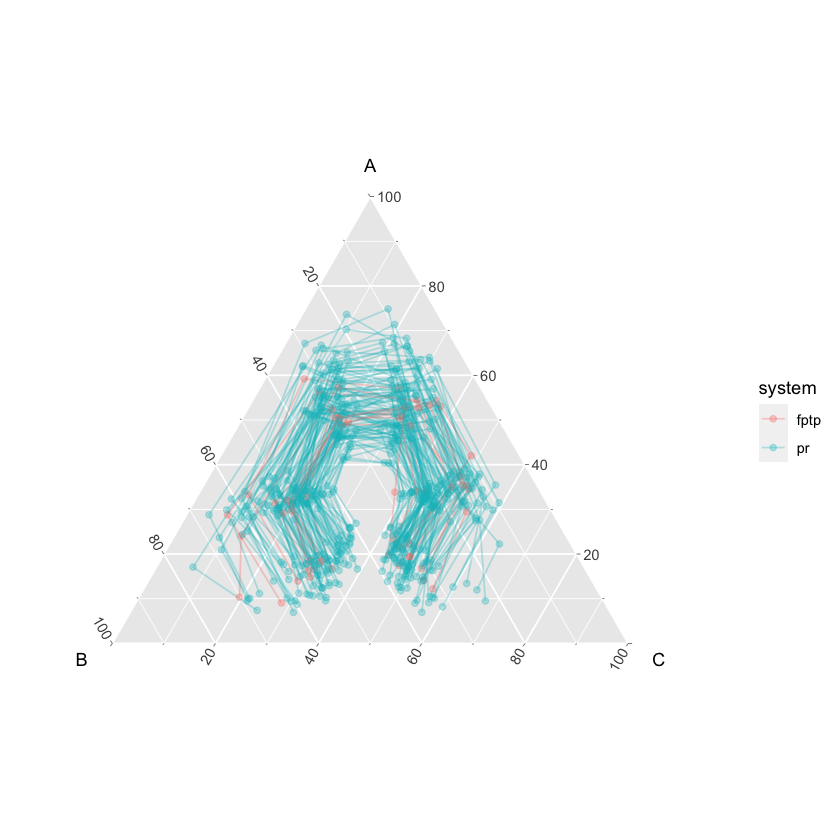

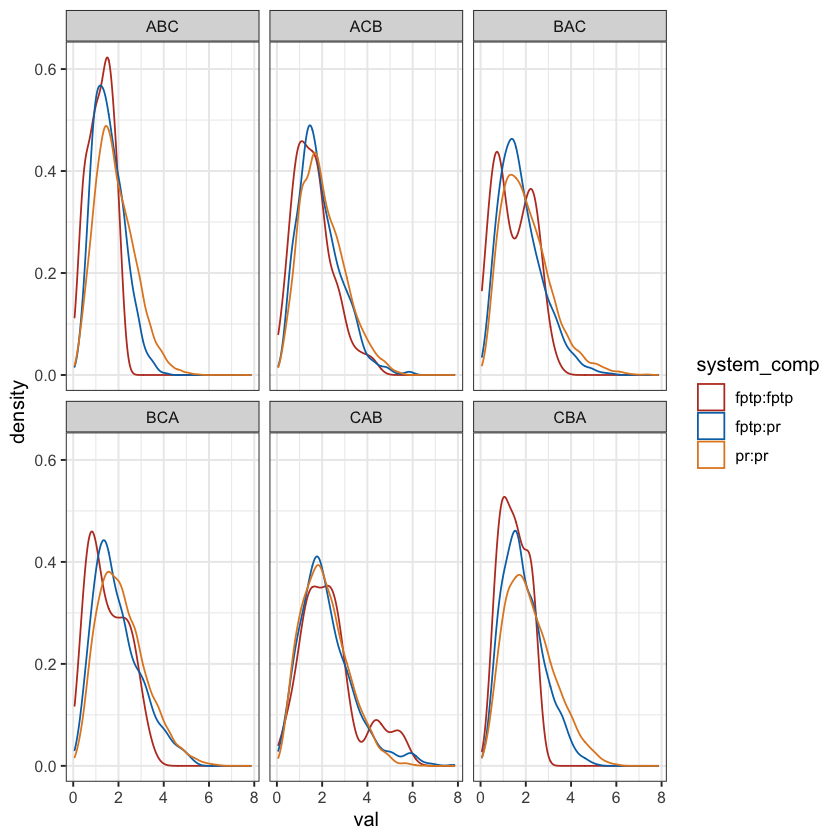

In [5]:
# Subset to plurality and PR only
summary_pr <- summary_df |>
  filter(system %in% c("fptp", "pr")) |>
  arrange(system, case, type)

# Plot the average preference profiles (by system)
ggtern(summary_pr, aes(B, A, C)) +
  geom_path(aes(colour = system, group = case), alpha = 0.3) +
  geom_point(aes(colour = system), alpha = 0.3)

# Calculate distance between cases (by same voter type)
out_map_pr <- map_dfr(
    c("BCA", "BAC", "ABC", "ACB", "CAB", "CBA"),
    ~ return_distdf(summary_pr, type = .x, case_supplied = TRUE)
  )

# The distance between average voter profiles isn't that different between FPTP and PR!
ggplot(out_map_pr, aes(x = val)) +
  geom_density(aes(colour = system_comp)) +
  facet_wrap(~ type) +
  theme_bw() +
  labs(colour = "System Comparison", x = "Distance") +
  scale_colour_nejm()

## Comparison between FPTP and RCV

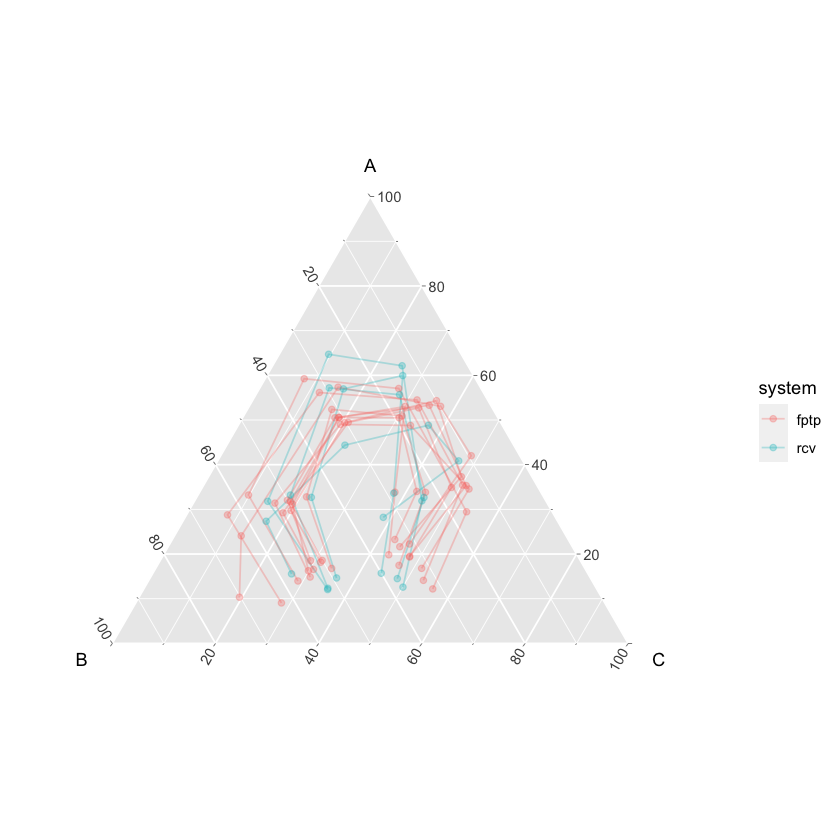

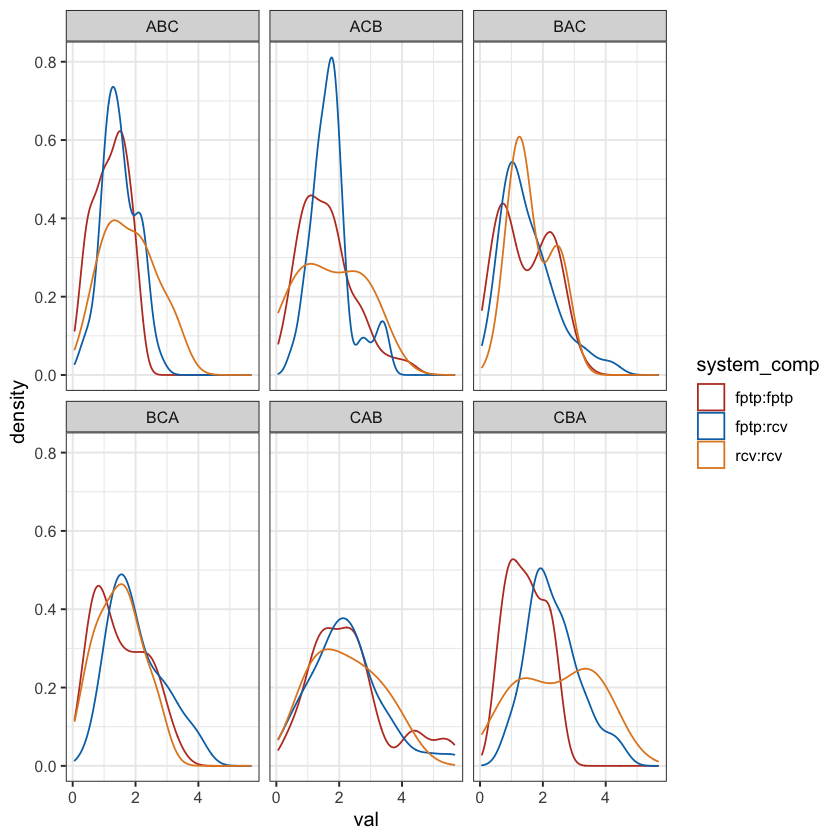

In [6]:
# Subset to plurality and RCV only
summary_pr <- summary_df |>
  filter(system %in% c("fptp", "rcv")) |>
  arrange(system, case, type)

# Plot the average preference profiles (by system)
ggtern(summary_pr, aes(B, A, C)) +
  geom_path(aes(colour = system, group = case), alpha = 0.3) +
  geom_point(aes(colour = system), alpha = 0.3)

# Calculate distance between cases (by same voter type)
out_map_pr <- map_dfr(
    c("BCA", "BAC", "ABC", "ACB", "CAB", "CBA"),
    ~ return_distdf(summary_pr, type = .x, case_supplied = TRUE)
  )

# The distance between average voter profiles isn't that different between FPTP and PR!
ggplot(out_map_pr, aes(x = val)) +
  geom_density(aes(colour = system_comp)) +
  facet_wrap(~ type) +
  theme_bw() +
  labs(colour = "System Comparison", x = "Distance") +
  scale_colour_nejm()